In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import editdistance
import pickle
import time
import keras
import argparse
import glob
#import fastss
import shutil
import sys
import time
import cv2
from keras.optimizers import SGD, Adam
from keras.callbacks import ModelCheckpoint

c:\users\jsson\anaconda3\envs\ai_library\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\jsson\anaconda3\envs\ai_library\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\jsson\anaconda3\envs\ai_library\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\users\jsson\anaconda3\envs\ai_library\lib\site-packages

In [2]:
from crnn_model import CRNN
from crnn_data import InputGenerator
from crnn_utils import decode
from utils.training import Logger, ModelSnapshot
from crnn_utils import alphabet87 as alphabet

In [3]:
interchangeble_pairs = [
                        # similar looks
                        ['I','l','1','i'],
                        ['B','8'],
                        ['o','0','O','D'],
                        ['B','8'],
                        ['G','6'],
                        ['U','V'],

                        # similar lower&upper cases
                        ['Y','y'],
                        ['V','v'] ,
                        ['X','x'],
                        ['Z','z','2'] ,
                        ['c','C'],
                        ['M','m'],
                        ['S','s'],
                        ['C','c'],
                        ['J','j'],

                        # this is added to filter out corner case 
                        ['a','o'],
                       ]

eps = 10**(-14)

In [4]:
def postprocess(gt,res):
    res_list = list(res)
    for i,char in enumerate(res) : 
        gt_char = gt[i]
        if char != gt_char : 
            for pair in interchangeble_pairs : 
                if char in pair and gt_char in pair:
                    res_list[i] = gt_char
                
    res = ''.join(res_list)
    return res

In [5]:
from data_ky import GTUtility

gt_util = GTUtility('data/ky_test/', phase='test')
print(gt_util)

Background              0
Text                   23

images                 20
objects                23
per image            1.15
no annotation           0



In [6]:
sess = tf.Session()

input_width = 256
#input_width = 1024
input_height = 32
batch_size = 128

input_shape = (input_width, input_height, 1)

model, model_pred = CRNN(input_shape, len(alphabet))
sess.run(tf.initializers.global_variables())
max_string_len = model_pred.output_shape[1]



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [8]:
gen_val = InputGenerator(gt_util, batch_size, alphabet, input_shape[:2], 
                        grayscale=True, max_string_len=max_string_len)
model.load_weights('./checkpoints/202006231539_crnn_lstm_ky/weights.020.h5')

In [9]:
g = gen_val.generate()
n = gt_util.num_boxes
#n = batch_size

mean_ed = 0
mean_ed_norm = 0
mean_character_recogniton_rate = 0
sum_ed = 0
char_count = 0
correct_word_count = 0 
correct_word_count_post = 0 

word_recognition_rate = 0

mean_character_recogniton_rate = 0
sum_ed = 0
char_count = 0

NEW epoch
NEW epoch
NEW epoch
NEW epoch
NEW epoch
gt : 155 pred :  155  ed =  1.000000


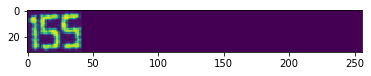

In [16]:
j = 0
while j < n:
    d = next(g)
    image = d[0]['image_input']    
    res = model_pred.predict(image)

    for i in range(len(res)):
        if not j < n: 
            break
        j += 1

        # best path, real ocr applications use beam search with dictionary and language model
        try:
            chars = [alphabet[c] for c in np.argmax(res[i], axis=1)]
            gt_str = d[0]['source_str'][i]
            res_str = decode(chars)
        except:
            continue
        #print(res_str)
        #if gt_str != res_str :
        #    print res_str,gt_str

        ed = editdistance.eval(gt_str, res_str)
        #ed = levenshtein(gt_str, res_str)
        ed_norm = ed / len(gt_str)
        mean_ed += ed
        mean_ed_norm += ed_norm


        sum_ed += ed
        char_count += len(gt_str)
        if ed == 0.: 
            correct_word_count += 1
            correct_word_count_post +=1 

        if ed != 0 : 
            try : 
                res = postprocess(gt_str,res_str)
                ed = editdistance.eval(gt_str,res)
            except : 
                res = res_str
                ed = ed
            if ed == 0 :
                correct_word_count_post += 1
            else : 
                print('gt : %s pred : %s  ed =  %f' %(gt_str, res_str,ed))       
            cv2.imwrite(os.path.join('weight_log',res_str+'.png'),d[0]['image_input'][i][::-1])
            image_to_show = np.squeeze(np.rot90(d[0]['image_input'][i][::-1],k=3))
            if ed != 0 : 
                plt.imshow(image_to_show)
                plt.show()

In [ ]:
mean_ed /= (j+eps)
mean_ed_norm /= (j+eps)
char_rate= (char_count-sum_ed) / (char_count+eps)
word_rate= correct_word_count / (j+eps)
word_rate_post = correct_word_count_post / (j)

In [ ]:
 print('%13s:%0.3f,%0.3f,%0.3f,%0.3f%0.3f\n' % (os.path.basename(weight),mean_ed,mean_ed_norm,char_rate,word_rate,word_rate_post))